In [ ]:
import pickle
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import rv_continuous

In [2]:
np.random.seed(42)
save_fig = False

In [3]:
domain = (-3, 3)

In [4]:
def p(x: np.ndarray) -> np.ndarray:
    """
    Compute the unnormalized target density function p(x).

    Parameters:
    x (np.ndarray): Input array of values.

    Returns:
    np.ndarray: Output array of the same shape as x, containing the computed density values.
    """
    px = np.exp(-(x**2) / 2) * (
        np.sin(x) ** 2 + 3 * np.cos(x) ** 2 * np.sin(7 * x) ** 2 + 1
    )
    # Set p(x) = 0 outside the interval [-3, 3]
    px = np.where(np.abs(x) <= 3, px, 0.0)
    return px


In [5]:
def compute_scaling_factor(
    p: Callable[[np.ndarray], np.ndarray],
    q: rv_continuous,
    domain: Tuple[float, float],
    print_output: bool = False,
    over_estimate: float = None,
) -> float:
    """
    Compute the scaling factor used in rejection sampling.

    Parameters:
    p (Callable[[np.ndarray], np.ndarray]): target density function. could be unnormalized
    q (rv_continuous): Proposal distribution from scipy.stats.
    print_output (bool): Whether to print the computed scaling factor.
    over_estimate (float): A factor to overestimate the scaling factor.

    Returns:
    float: The computed scaling factor.
    """

    domain_min, domain_max = domain
    x = np.linspace(domain_min, domain_max, 1000)

    # Evaluate p(x) and q(x) over x
    p_values = p(x)
    q_values = q.pdf(x)

    ratio_pq = np.divide(
        p_values, q_values, out=np.zeros_like(p_values), where=q_values != 0
    )

    M_estimate = np.max(ratio_pq)
    M = M_estimate

    if over_estimate:
        M = M * over_estimate

    if print_output:
        print(f"Estimated scaling constant M: {M}")

    return M


In [6]:
def plot_target_vs_proposal_distribution(
    p: Callable[[np.ndarray], np.ndarray],
    q: rv_continuous,
    domain: Tuple[float, float],
    name: str,
):
    """
    Plots the target density function p(x) and the proposal density q(x) for visualization.

    Parameters:
    p (Callable[[np.ndarray], np.ndarray]): target density function. could be unnormalized
    q (rv_continuous): Proposal distribution from scipy.stats.
    name (str): Name of the proposal distribution. Used for printing the legend.
    """

    # Generate x-values over which to evaluate the functions
    domain_min, domain_max = domain
    x = np.linspace(domain_min - 3, domain_max + 3, 1000)

    # Evaluate p(x) and q(x) over x
    p_values = p(x)
    q_values = q.pdf(x)

    M = compute_scaling_factor(p, q, domain)

    # Compute M * q(x)
    Mq_values = M * q_values

    # Plot the functions
    plt.figure(figsize=(10, 6))
    plt.plot(x, p_values, label="Unnormalized target density $p(x)$", color="blue")
    plt.plot(
        x,
        q_values,
        label="Normalized " + name + " proposal density $q(x)",
        color="red",
        linestyle="--",
    )
    plt.plot(
        x,
        Mq_values,
        label="Normalized Adjusted "
        + name
        + " proposal density $M q(x), M ={:.2f}".format(M),
        color="green",
        linestyle=":",
    )

    # Highlight the interval [-3, 3]
    plt.axvline(x=domain_min, color="gray", linestyle=":")
    plt.axvline(x=domain_max, color="gray", linestyle=":")
    plt.fill_between(
        x, 0, p_values, where=(np.abs(x) > domain_max), color="blue", alpha=0.1
    )
    plt.fill_between(
        x, 0, q_values, where=(np.abs(x) > domain_max), color="red", alpha=0.1
    )

    plt.title("Comparison of target density $p(x)$ and proposal density $q(x)$")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend(loc="best")
    plt.ylim(0, 5)
    plt.grid(False)

    if save_fig:
        plt.savefig("target_vs_proposal_" + name + ".png", dpi=600)

    plt.show()

In [7]:
def rejection_sampling(
    n_samples: int,
    target_dist: Callable[[np.ndarray], np.ndarray],
    proposal_dist: rv_continuous,
    domain: Tuple[float, float],
    batch_size: int = 100,
) -> np.ndarray:
    """
    Perform rejection sampling to generate samples from the target distribution.

    Parameters:
    n_samples (int): Number of samples to generate.
    target_dist (Callable[[np.ndarray], np.ndarray]): Unnormalized target density function.
    proposal_dist (rv_continuous): Proposal distribution from scipy.stats.

    Returns:
    np.ndarray: Array of generated samples with size (n_samples,).
    float: Percentage of samples rejected.
    """
    M = compute_scaling_factor(target_dist, proposal_dist, domain)

    rejected = 0

    samples = []
    while len(samples) < n_samples:
        # Sample x_candidate from the proposal distribution
        x_candidate = proposal_dist.rvs(size=batch_size)

        # Evaluate target_dist(x_candidate) and proposal_dist(x_candidate)
        p_x_candidate = target_dist(x_candidate)
        q_x_candidate = proposal_dist.pdf(x_candidate)

        # Compute acceptance probability
        acceptance_ratio = p_x_candidate / (M * q_x_candidate)

        # Generate a uniform random number u ∈ [0, 1)
        u = stats.uniform.rvs(size=batch_size)

        # Accept or reject the candidate sample
        accept = u < acceptance_ratio

        if batch_size == 1:
            if accept[0] == np.False_:
                rejected += 1

        accepted_x_batch = x_candidate[accept]

        # if u < acceptance_ratio:
        samples.extend(accepted_x_batch)

    return np.array(samples[:n_samples]), rejected

In [8]:
def compute_expectation(p, q, domain, n_samples, batch_size=100, verbose=True):
    samples, rejected = rejection_sampling(
        n_samples, p, q, domain, batch_size=batch_size
    )
    E_x2 = np.mean(samples**2)
    if verbose:
        print(
            f"Estimated E[X^2] using rejection sampling: {E_x2:.4f} and samples: {n_samples}"
        )
        print(f"Number of rejected samples: {rejected}")
    return E_x2

In [9]:
n_samples = 100000

In [10]:
uniform = stats.uniform(loc=-3, scale=6)


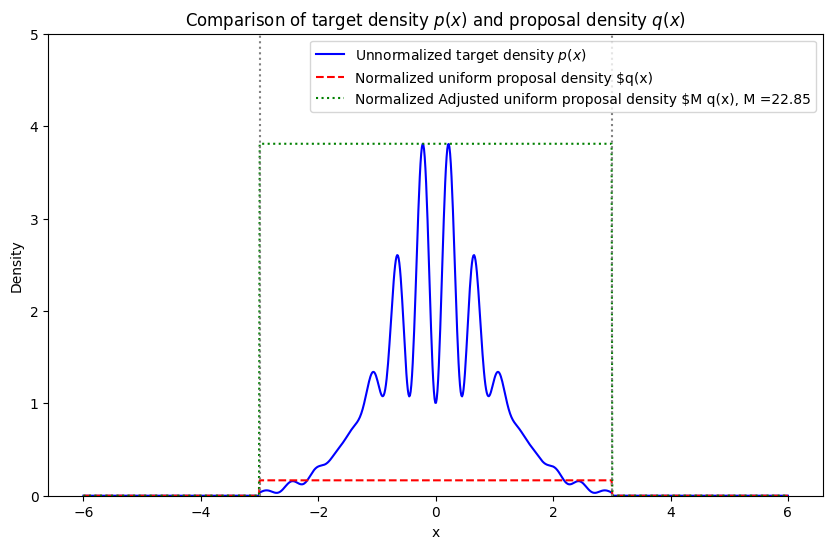

In [11]:
plot_target_vs_proposal_distribution(p, uniform, domain, "uniform")

In [12]:
compute_expectation(p, uniform, domain, n_samples, batch_size=1, verbose=True)

Estimated E[X^2] using rejection sampling: 0.9168 and samples: 100000
Number of rejected samples: 301629


0.9167780648982846

In [13]:
gaussian = stats.norm(loc=0, scale=1)

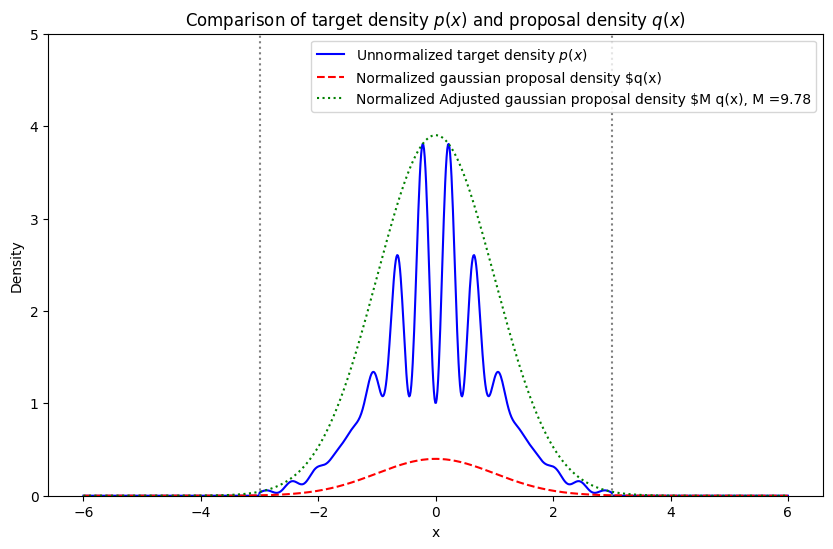

In [14]:
plot_target_vs_proposal_distribution(p, gaussian, (-3, 3), "gaussian")

In [15]:
compute_expectation(p, gaussian, domain, n_samples, batch_size=1, verbose=True)

Estimated E[X^2] using rejection sampling: 0.9207 and samples: 100000
Number of rejected samples: 71701


0.9206876488224247

In [16]:
number_of_samples = [10, 100, 1000]
proposal_distributions = [uniform, gaussian]
trials = 100

In [17]:
# Initialize an empty list to collect the data
data = []

In [18]:
for trial in range(trials):
    for n_samples in number_of_samples:
        for q in proposal_distributions:
            estimator = compute_expectation(
                p, q, domain, n_samples, batch_size=n_samples, verbose=False
            )
            # Create a string representation of q
            q_repr = f"rejection sampling {q.dist.name}"
            data.append(
                {
                    "trial": trial,
                    "samples": n_samples,
                    "sampling method": q_repr,
                    "estimator": estimator,
                }
            )


In [19]:
def importance_sampling(
    target_dist: Callable[[np.ndarray], np.ndarray],
    proposal_dist: rv_continuous,
    num_samples: int = 10000,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform importance sampling to estimate the expectation of a target distribution.

    Parameters:
    target_dist (Callable[[np.ndarray], np.ndarray]): The target distribution function that takes an array of samples and returns their densities.
    proposal_dist (rv_continuous): The proposal distribution from which to sample.
    num_samples (int, optional): The number of samples to draw from the proposal distribution. Default is 10000.

    Returns:
    tuple: A tuple containing:
        - weights (np.ndarray): The normalized importance weights.
        - samples (np.ndarray): The samples drawn from the proposal distribution.
    """
    # Sample from the proposal distribution
    samples = proposal_dist.rvs(size=num_samples)

    # Compute the unnormalized target density for these samples
    p_x = target_dist(samples)

    # Compute the proposal density for these samples
    q_x = proposal_dist.pdf(samples)

    # Compute the self-normalized weights
    weights = p_x / q_x
    weights /= np.sum(weights)  # Normalize the weights

    return weights, samples

In [20]:
# Calculate the expectation
weights, samples = importance_sampling(p, gaussian)
expectation = np.sum(weights * samples**2)
print("Expected value of x^2:", expectation)

Expected value of x^2: 0.9320702864097906


In [21]:
for trial in range(trials):
    for n_samples in number_of_samples:
        weights, samples = importance_sampling(p, q, num_samples=n_samples)
        estimator = np.sum(weights * samples**2)
        # Create a string representation of q
        q_repr = "importance sampling norm"
        data.append(
            {
                "trial": trial,
                "samples": n_samples,
                "sampling method": q_repr,
                "estimator": estimator,
            }
        )


In [25]:
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

In [ ]:
# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# Compute mean and standard deviation for each combination of n_samples and q
grouped = df.groupby(["samples", "sampling method"])["estimator"].agg(["mean", "std"])


print(grouped)

                                        mean       std
samples sampling method                               
10      importance sampling norm    0.928537  0.357609
        rejection sampling norm     0.857527  0.375900
        rejection sampling uniform  0.942758  0.456646
100     importance sampling norm    0.914220  0.131331
        rejection sampling norm     0.927552  0.131934
        rejection sampling uniform  0.915646  0.138565
1000    importance sampling norm    0.910965  0.042440
        rejection sampling norm     0.913647  0.044586
        rejection sampling uniform  0.920091  0.035158


In [ ]:
print(grouped.to_latex())

In [ ]:
x = np.linspace(-3, 3, 1000)
px = p(x)
fx = x**2
qx = q.pdf(x)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(x, px, label="$p(x)$", color="blue")
ax.plot(x, fx, label="$f(x)=x^2$", color="green")
ax.plot(x, qx, label="$q(x)$", color="red", linestyle="--")
ax.set_title("Importance sampling using the Gaussian distribution")
plt.legend(loc="best")
if save_fig:
    plt.savefig("importance_sampling.png", dpi=600)
plt.show()

In [ ]:
mean_unstacked = grouped["mean"].unstack("sampling method")

ax = mean_unstacked.plot(kind="line", marker="o")
ax.set_xlabel("Number of samples")
ax.set_ylabel("Mean")
ax.set_title("Mean for Estimator vs number of samples for each sampling method")
plt.legend(title="sampling method")
if save_fig:
    plt.savefig("mean_estimator.png", dpi=600)
plt.show()

In [ ]:
std_unstacked = grouped["std"].unstack("sampling method")

ax = std_unstacked.plot(kind="line", marker="o")
ax.set_xlabel("Number of samples")
ax.set_ylabel("Standard deviation")
ax.set_title(
    "Standard Deviation for Estimator vs number of samples for each sampling method"
)
plt.legend(title="sampling method")
if save_fig:
    plt.savefig("std_estimator.png", dpi=600)
plt.show()

In [ ]:
# Python package versions used
%load_ext watermark
%watermark --a "Carsten Jørgensen"
%watermark --e "carstenj@gmail.com"
%watermark -m -v -i -iv